<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/5_Forecasting%20%7C%20ML_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install wandb -qqq
import wandb
wandb.login()

In [6]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/final.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
# from 3D to 2D array
#X_train = X_train[:, :, 0]
#X_test = X_test[:, :, 0]
#X_val = X_val[:, :, 0]

In [ ]:
X = df[['% Silica Feed', 'Amina Flow', 'Flotation Column 01 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       '% Iron Concentrate']]
y = df[['% Silica Concentrate']]

X_train, y_train = X[:2664], y[:2664]
X_test, y_test = X[2664:3235], y[2664:3235]
X_val, y_val = X[3235:], y[3235:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

In [ ]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
    mae = np.mean(np.abs(forecast - actual))    
    rmse = np.mean((forecast - actual)**2)**.5  

    return mape, mae, rmse

In [39]:
sweep_config = {
    "method": "random", # try grid or random
    "metric": {
      "name": "mean_squared_error",
      "goal": "minimize"   
    },
    "parameters": {
        "booster": {
            "values": ["gbtree","gblinear"]
        },
        "max_depth": {
            "values": [2, 3, 6, 7, 9, 12]
        },
        "n_estimators": {
            "values": [50, 100, 200]
        },
        "learning_rate": {
            "values": [0.01, 0.05, 0.02, 0.025]
        },
        "subsample": {
            "values": [1, 0.5, 0.3]
        },
        "colsample_bytree": {
            "values": [0.3, 0.7]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="XGBoost")

Create sweep with ID: 8amsudxb
Sweep URL: https://wandb.ai/malekkamoua/XGBoost/sweeps/8amsudxb


In [40]:
from math import sqrt
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE

def train():
  config_defaults = {
      'n_estimators': 200,
      "booster": "gbtree",
      "max_depth": 3,
      "learning_rate": 0.1,
    }

  wandb.init(config=config_defaults)  # defaults are over-ridden during the sweep
  config = wandb.config

  model = XGBRegressor(n_estimators = config.n_estimators,
                      booster = config.booster,
                      max_depth = config.max_depth,
                      learning_rate = config.learning_rate,
                      objective ='reg:squarederror',
                      verbosity = 0)

  model.fit(X_train, y_train)

  # Predict the model
  pred = model.predict(X_test)
  mean_squared_error = np.sqrt(MSE(y_test, pred))
  print("mean_squared_error : % f" %(mean_squared_error))

  wandb.log({"mean_squared_error": mean_squared_error})

In [ ]:
wandb.agent(sweep_id, train, count=25)

In [45]:
model = XGBRegressor(n_estimators = 100,
                     max_depth = 6,
                     booster='gbtree',
                     learning_rate = 0.025,
                     colsample_bytree = 0.7,
                     objective ='reg:squarederror',
                     verbosity = 0)
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
y_test = y_test.reset_index().drop('index', axis=1)
y_test['XGBOOST_predictions'] = pd.Series(predictions_test)

predictions_val = model.predict(X_val)
y_val = y_val.reset_index().drop('index', axis=1)
y_val['XGBOOST_predictions'] = pd.Series(predictions_val)

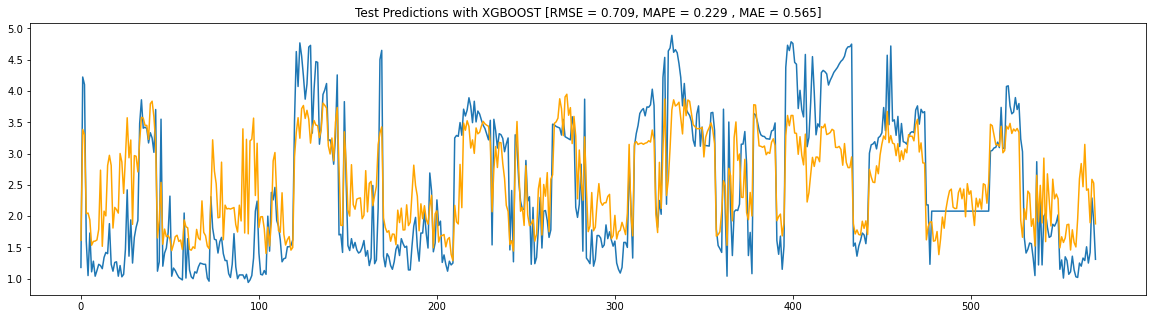

In [46]:
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error

mape, mae, rmse = forecast_accuracy(y_test['% Silica Concentrate'], predictions_test)

fig, ax = plt.subplots(figsize=(20,5))

# plot forecasts against actual outcomes
pyplot.plot(y_test['% Silica Concentrate'])
pyplot.plot(predictions_test, color='orange')
plt.title("Test Predictions with XGBOOST [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
pyplot.show()

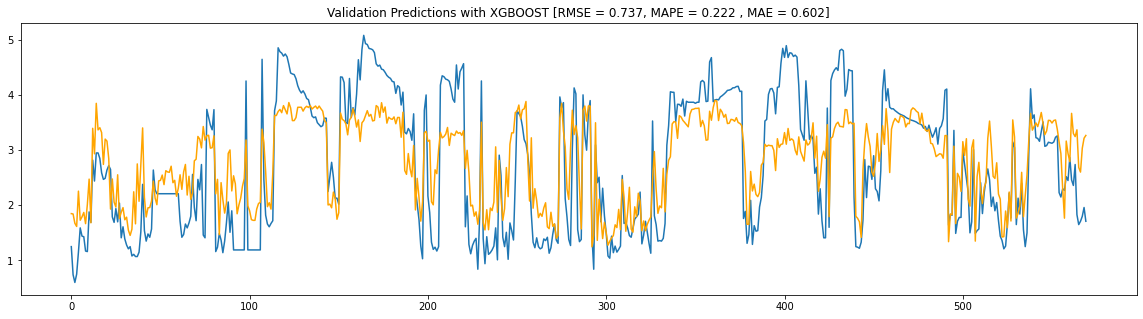

In [44]:
fig, ax = plt.subplots(figsize=(20,5))

mape, mae, rmse = forecast_accuracy(y_val['% Silica Concentrate'], predictions_val)

# plot forecasts against actual outcomes
pyplot.plot(y_val['% Silica Concentrate'])
pyplot.plot(predictions_val, color='orange')
plt.title("Validation Predictions with XGBOOST [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
pyplot.show()

In [64]:
from sklearn.ensemble import RandomForestRegressor

sweep_rf_config = {
    "method": "random", # try grid or random
    "metric": {
      "name": "mean_squared_error",
      "goal": "minimize"   
    },
    "parameters": {
        "max_depth": {
            "values": [2, 3, 6, 7, 9, 12]
        },
        "n_estimators": {
            "values": [50, 100, 200]
        },
        
        "max_features": {
            "values": ['auto']
        },
        "min_samples_split": {
            "values": [3, 5, 7]
        }
    }
}

sweep_rf_id = wandb.sweep(sweep_rf_config, project="RandomForest")

def train_rf():
  config_defaults = {
      'n_estimators': 200,
      "max_depth": 3,
      "max_features": 'auto',
      "min_samples_split": 3
    }

  wandb.init(config=config_defaults)  # defaults are over-ridden during the sweep
  config = wandb.config

  model = RandomForestRegressor(n_estimators = config.n_estimators,
                                max_depth = config.max_depth,
                                min_samples_split = config.min_samples_split,
                                max_features= config.max_features)

  model.fit(X_train, y_train)

  # Predict the model
  pred = model.predict(X_test)
  mean_squared_error = np.sqrt(MSE(y_test, pred))
  print("mean_squared_error : % f" %(mean_squared_error))

  wandb.log({"mean_squared_error": mean_squared_error})

Create sweep with ID: dzn6qxry
Sweep URL: https://wandb.ai/malekkamoua/RandomForest/sweeps/dzn6qxry


In [ ]:
wandb.agent(sweep_rf_id, train_rf, count=25)

In [ ]:
model = RandomForestRegressor(n_estimators=50,
                              max_features='auto',
                              min_samples_split = 7,
                              max_depth = 2)

model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
y_test = y_test.reset_index().drop('index', axis=1)
y_test['randomeForest_predictions'] = pd.Series(predictions_test)

predictions_val = model.predict(X_val)
y_val = y_val.reset_index().drop('index', axis=1)
y_val['randomeForest_predictions'] = pd.Series(predictions_val)

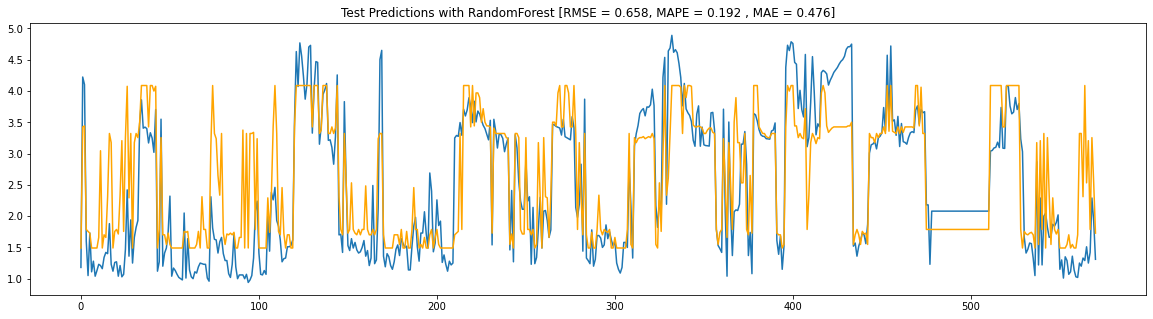

In [67]:
fig, ax = plt.subplots(figsize=(20,5))

mape, mae, rmse = forecast_accuracy(y_test['% Silica Concentrate'], predictions_test)

# plot forecasts against actual outcomes
pyplot.plot(y_test['% Silica Concentrate'])
pyplot.plot(predictions_test, color='orange')
plt.title("Test Predictions with RandomForest [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
pyplot.show()

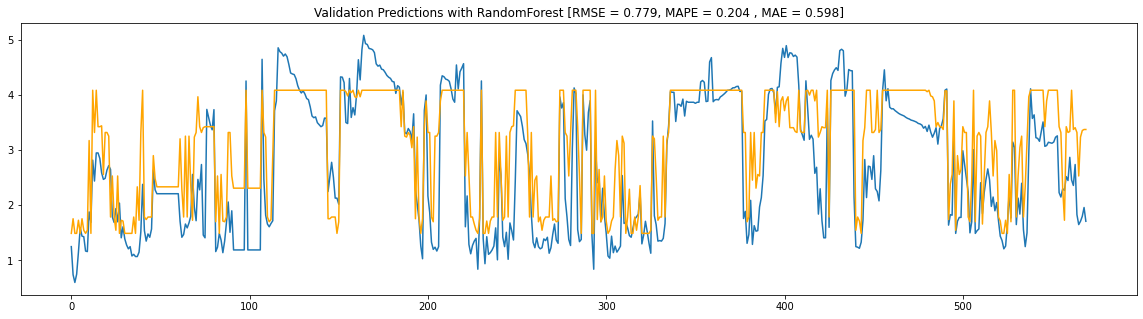

In [68]:
fig, ax = plt.subplots(figsize=(20,5))

mape, mae, rmse = forecast_accuracy(y_val['% Silica Concentrate'], predictions_val)

# plot forecasts against actual outcomes
pyplot.plot(y_val['% Silica Concentrate'])
pyplot.plot(predictions_val, color='orange')
plt.title("Validation Predictions with RandomForest [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
pyplot.show()